In [3]:
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, accuracy_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    demographic_parity_difference,
    MetricFrame,
    true_negative_rate,
    true_positive_rate
)

from fairlearn.datasets import fetch_adult
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from metrics import equality_opportunity_difference, predictive_equality_difference, metric_evaluation, get_metric_evaluation


import numpy as np
import optuna
import tqdm as notebook_tqdm

import dill
import optuna
import plotly

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## One simulation

In [ ]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

In [ ]:
file_name = 'recall-fpr-lgbm-motpe-succesivehalving-100trials-1sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [ ]:
import matplotlib.pyplot as plt
results_df = results[0].trials_dataframe()

In [ ]:
metric_list = []
n_sim = 0 

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, random_state=n_sim, stratify=y
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

pipeline.fit(X_train, y_train)
y_pred_original = pipeline.predict(X_test)  

for i in range(len(results[n_sim].best_trials)):
    best_params = {key.replace('lgbm_',''):value for key, value in results[n_sim].best_trials[i].params.items()}
    pipeline['classifier'].set_params(**best_params)
    pipeline.fit(X_train, y_train)
    y_pred_optimized = pipeline.predict(X_test)  
    metric_list.append(
        metric_evaluation(
            y_true=y_test, 
            y_pred=y_pred_optimized, 
            sensitive_features=X_test['sex']
            )
    )

In [ ]:
fair_metric_1 = [get_metric_evaluation(metric)['predictive equality difference'] for metric in metric_list]
fair_metric_2 = [get_metric_evaluation(metric)['equality opportunity difference'] for metric in metric_list]
fair_metric_3 = [get_metric_evaluation(metric)['average absolute odds difference'] for metric in metric_list]
fair_metric_4 = [get_metric_evaluation(metric)['disparity difference'] for metric in metric_list]
fair_metric_train = [results[0].best_trials[i].values[0] for i in range(len(results[0].best_trials))]


In [ ]:
fairness_metrics = list(zip(fair_metric_train, fair_metric_1, fair_metric_2, fair_metric_3, fair_metric_4))
fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
colors = ['DodgerBlue','SkyBlue','LightCoral','MediumPurple','SandyBrown']
labels = ['Predictive Equality diff', 'Predictive Equality Diff', 
          'Equality Opportunity Diff', 'Average Absolute Odds Diff',
          'Demographic Disparity Diff']


fig, ax = plt.subplots(figsize=(10,6))
for i, (color, label) in enumerate(zip(colors,labels)):
    if i != 0:
        ax.scatter(range(len(fair_metric_1)), list(zip(*fairness_metrics_))[i], c=color, label=label)

ax.legend()
ax.grid(True)

plt.show()


In [ ]:
model_metric_train = [results[0].best_trials[i].values[1] for i in range(len(results[0].best_trials))]
model_metric_1 = [metric.overall['recall'] for metric in metric_list]
model_metric_2 = [metric.overall['precision'] for metric in metric_list]
model_metric_3 = [metric.overall['f1 score'] for metric in metric_list]
model_metric_4 = [metric.overall['accuracy'] for metric in metric_list]
model_metrics = list(zip(model_metric_train, model_metric_1, model_metric_2, model_metric_3, model_metric_4))
model_metrics_ = sorted(model_metrics, key = lambda x: x[0])


In [ ]:
colors = ['DodgerBlue','SkyBlue','LightCoral','MediumPurple','SandyBrown']
labels = ['Recall', 'Recall', 'Precision', 'F1 Score','Accuracy']


fig, ax = plt.subplots(figsize=(10,6))
for i, (color, label) in enumerate(zip(colors,labels)):
    if i != 0:
        ax.scatter(range(len(model_metric_train)), list(zip(*model_metrics_))[i], c=color, label=label)

ax.legend()
ax.grid(True)

plt.show()


In [ ]:
fair_metric_train = [results[0].best_trials[i].values[0] for i in range(len(results[0].best_trials))]
model_metric_train = [results[0].best_trials[i].values[1] for i in range(len(results[0].best_trials))]

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

plt.scatter(fair_metric_train, model_metric_train)

In [ ]:
fairness_metrics = list(zip(fair_metric_train, fair_metric))
fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])


In [ ]:
plt.scatter(range(len(fair_metric_train)),list(zip(*fairness_metrics_))[0])
plt.scatter(range(len(fair_metric_train)), list(zip(*fairness_metrics_))[1])

In [ ]:
model_metrics = list(zip(model_metric_train, model_metric))
model_metrics_ = sorted(model_metrics, key = lambda x: x[0])

In [ ]:
plt.scatter(range(len(fair_metric_train)),list(zip(*model_metrics_))[0])
plt.scatter(range(len(fair_metric_train)), list(zip(*model_metrics_))[1])

In [ ]:
n = 1
best_params = {key.replace('lgbm_',''):value for key, value in results.best_trials[n].params.items()}
pipeline['classifier'].set_params(**best_params)

In [ ]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
fair_value = np.abs(equalized_odds_difference(y_test, y_pred, sensitive_features=A_test))
model_value = f1_score(y_test, y_pred) 
print(fair_value)
print(model_value)

## Several Simulations

In [3]:
file_name = 'recall-fpr-lgbm-motpe-succesivehalving-100trials-4sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

FileNotFoundError: [Errno 2] No such file or directory: 'recall-fpr-lgbm-motpe-succesivehalving-100trials-4sim.pkl'

In [ ]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

In [ ]:
fair_sim_u = []
model_sim_u = []
fair_sim = []
model_sim = []
res_fair_sim = []
res_model_sim = []
for sim_n,res in enumerate(results):
    print(sim_n)
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, stratify=y, random_state=sim_n
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    pipeline.steps.pop(1)
    pipeline.steps.insert(1,('classifier',LGBMClassifier(n_jobs=-1)))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fair_sim_u.append((np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test))))
    model_sim_u.append(recall_score(y_test, y_pred))

    fair_value = []
    model_value = []
    res_fair_value = []
    res_model_value = []
    for i in range(len(res.best_trials)):
        best_params = {key.replace('lgbm_',''):value for key, value in res.best_trials[i].params.items()}
        pipeline['classifier'].set_params(**best_params)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)  
        res_fair_value.append(res.best_trials[i].values[0])
        res_model_value.append(res.best_trials[i].values[1])
        fair_value.append(np.abs(predictive_equality_difference(y_test, y_pred, sensitive_features=A_test)))
        model_value.append(recall_score(y_test, y_pred))

    res_fair_sim.append(res_fair_value)
    res_model_sim.append(res_model_value)
    fair_sim.append(fair_value)
    model_sim.append(model_value)


In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    ax.scatter(res_fair_sim[i], res_model_sim[i])
    ax.scatter(fair_sim_u[i], model_sim_u[i])
    #order = results[i].F[:,0].argsort()
    #ax.scatter(range(len(fair_sim[i])), results[i].F[order,0])
    #ax.scatter(fair_sim[i], model_sim[i])
    #ax.scatter(fair_sim_u[i], model_sim_u[i])

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[0])
    ax.scatter(len(res_fair_sim[i]), fair_sim_u[i])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[1])

In [ ]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_model_sim)),axes.ravel()):
    performance_metrics = list(zip(res_model_sim[i], model_sim[i]))
    performance_metrics_ = sorted(performance_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[0])
    ax.scatter(len(res_model_sim[i]), model_sim_u[i])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[1])

In [ ]:
np.array(list(zip(*fairness_metrics_))[0])-np.array(list(zip(*fairness_metrics_))[1])

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*fairness_metrics_))[0])-np.array(list(zip(*fairness_metrics_))[1])
    ax.hist(fair_residuals)

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    model_metrics = list(zip(res_model_sim[i], model_sim[i]))
    model_metrics_ = sorted(model_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*model_metrics_))[0])-np.array(list(zip(*model_metrics_))[1])
    ax.hist(fair_residuals)

## Different Models

In [4]:
file_name = 'f1-parity-models-motpe-succesivehalving-100trials-4sim.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [5]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]


numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1),
        ),
    ]
)

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
import re

#results = {}
metrics_sim_u = []
metrics_sim = []
res_sim = []
models_sim_u = []
models_sim = []
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), LGBMClassifier()]
for sim_n,res in enumerate(results[0:1]):
    print(sim_n)
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.8, stratify=y, random_state=sim_n
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    metrics_sim_u_aux = []
    models_sim_u_aux = []
    for model in models:
        print(type(model).__name__)
        models_sim_u_aux.append(type(model).__name__)
        pipeline.steps.pop(1)
        pipeline.steps.insert(1,('classifier', model))
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metrics_sim_u_aux.append(
            metric_evaluation(
                        y_true=y_test, 
                        y_pred=y_pred, 
                        sensitive_features=X_test['sex']
                        )
                )
    metrics_sim_u.append(metrics_sim_u_aux)
    models_sim_u.append(models_sim_u_aux)

    models_sim_aux = []
    metrics_sim_aux = []
    res_value = []
    for i in range(len(res.best_trials)):
        best_params = {re.sub('^[a-z]+_','',key):value for key, value in res.best_trials[i].params.items()}
        pipeline.steps.pop(1)
        classifier_name = best_params.pop('classifier')
        models_sim_aux.append(classifier_name)
        if classifier_name == "logit": 
            pipeline.steps.insert(1,('classifier', LogisticRegression()))
        elif classifier_name =="RF":
            pipeline.steps.insert(1,('classifier', RandomForestClassifier()))
        elif classifier_name =="LGBM":
            pipeline.steps.insert(1,('classifier', LGBMClassifier()))
        elif classifier_name =="GBM":
            pipeline.steps.insert(1,('classifier', GradientBoostingClassifier()))
        pipeline['classifier'].set_params(**best_params)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)  
        res_value.append((res.best_trials[i].values[0],res.best_trials[i].values[1]))
        metrics_sim_aux.append(
            metric_evaluation(
                        y_true=y_test, 
                        y_pred=y_pred, 
                        sensitive_features=X_test['sex']
                        )
                )
    models_sim.append(models_sim_aux)
    res_sim.append(res_value)
    metrics_sim.append(metrics_sim_aux)


0
LogisticRegression


/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier


KeyboardInterrupt: 

In [178]:
results_dict = {}
results_dict['res_sim'] = res_sim
results_dict['models_sim'] = models_sim
results_dict['metrics_sim'] = metrics_sim
results_dict['metrics_sim_u'] = metrics_sim_u
results_dict['models_sim_u'] = models_sim_u


In [870]:
import dill
file_name = 'f1-parity-models-dashboard.pkl'
with open(file_name, 'wb') as file:
    dill.dump(results_dict, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "f1-parity-models-dashboard.pkl"


In [895]:
import dill
file_name = '../pages/f1-parity-models-dashboard.pkl'
with open(file_name, 'rb') as in_strm:
    results_dict = dill.load(in_strm)

In [9]:
def metrics_scatter(metrics, labels, colors):
    fig, ax = plt.subplots(figsize=(10,6))
    for i, (color, label) in enumerate(zip(colors,labels)):
        if i != 0:
            y = list(zip(*metrics))[i]
            ax.scatter(range(len(y)), y, c=color, label=label)

    ax.legend()
    ax.grid(True)
    plt.show()

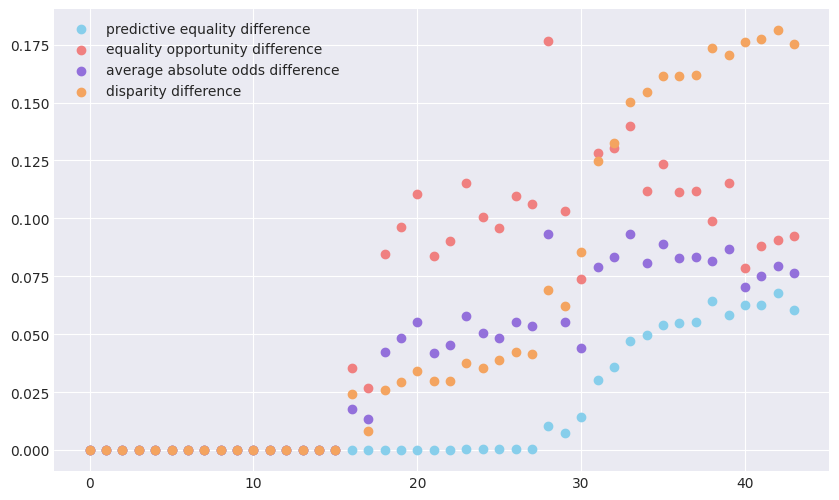

In [45]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

fair_metrics_u_dict = {}
fair_metrics_dict = {}
metrics = [
    'predictive equality difference', 
    'equality opportunity difference',
    'average absolute odds difference',
    'disparity difference'
    ]

fair_metrics_dict['train_fair'],_ = list(zip(*results_dict['res_sim'][0]))
for metric in metrics:
    fair_metrics_dict[metric] = [get_metric_evaluation(metric_frame)[metric] for metric_frame in results_dict['metrics_sim'][0]]
    fair_metrics_u_dict[metric] = [get_metric_evaluation(metric_frame)[metric] for metric_frame in results_dict['metrics_sim_u'][0]]


fair_metrics = list(zip(* fair_metrics_dict.values()))
fair_metrics_sorted = sorted(fair_metrics, key = lambda x: x[0])

colors = ['DodgerBlue','SkyBlue','LightCoral','MediumPurple','SandyBrown']
labels = ['train'] + metrics
metrics_scatter(fair_metrics_sorted, labels, colors)

In [149]:

def eval_metrics_graph(df_metrics, labels, colors, title):
    fig = go.Figure()
    for i, (color, label) in enumerate(zip(colors,labels)):
        fig.add_trace(
            go.Scatter(
                name = label.capitalize(),
                x= df_metrics.index, 
                y= df_metrics[label], 
                customdata = df_metrics.model,
                mode = 'markers',
                marker_color = color,
                hovertemplate = "<br>".join([
                    "Ranking: %{x}",
                    label.capitalize() +" (test): %{y:,.3f}",
                    "Model: %{customdata}",
                ])
        ))
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
            ),
        title = title
    )
    return fig


metrics = [
    'recall', 
    'precision',
    'f1 score',
    'accuracy'
    ]
colors = ['SkyBlue','LightCoral','MediumPurple','SandyBrown']
title = 'Model performance metrics'
eval_metrics_graph(df_metrics_sorted, metrics, colors, title)

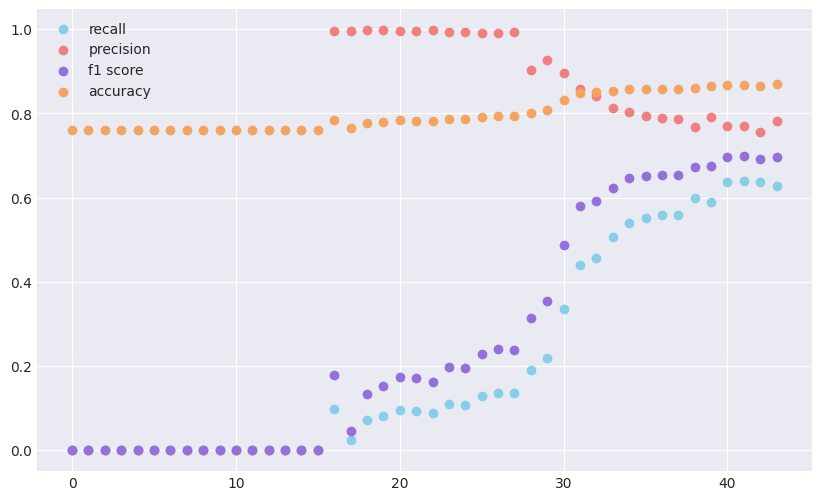

In [46]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

model_metrics_dict = {}
model_metrics_u_dict = {}
metrics = [
    'recall', 
    'precision',
    'f1 score',
    'accuracy'
    ]

_,model_metrics_dict['train_model'] = list(zip(*results_dict['res_sim'][0]))
for metric in metrics:
    model_metrics_dict[metric] = [metric_frame.overall[metric] for metric_frame in results_dict['metrics_sim'][0]]
    model_metrics_u_dict[metric] = [metric_frame.overall[metric] for metric_frame in results_dict['metrics_sim_u'][0]]

model_metrics = list(zip(*model_metrics_dict.values()))
model_metrics_sorted = sorted(model_metrics, key = lambda x: x[0])

colors = ['DodgerBlue','SkyBlue','LightCoral','MediumPurple','SandyBrown']
labels = ['train'] + metrics
metrics_scatter(model_metrics_sorted, labels, colors)

In [423]:
import pandas as pd

def create_df_metrics(fair_metrics, model_metrics):
    df_fair = pd.DataFrame.from_dict(fair_metrics)
    df_model = pd.DataFrame.from_dict(model_metrics)
    df_metrics = pd.concat([df_fair,df_model], axis = 1)
    return df_metrics

df_metrics = create_df_metrics(fair_metrics_dict, model_metrics_dict)
df_metrics['model'] = results_dict['models_sim'][0]
new_index = df_metrics[df_metrics['train_model'] != 0].index
df_metrics = df_metrics[df_metrics['train_model'] != 0].reset_index(drop = True)


In [838]:
int()/3)

1

In [823]:
df_metrics

,train_fair,predictive equality difference,equality opportunity difference,average absolute odds difference,disparity difference,train_model,recall,precision,f1 score,accuracy,model
0,0.051179,0.010407,0.176387,0.093397,0.068927,0.274766,0.190160,0.903915,0.314218,0.801377,RF
1,0.155837,0.058206,0.115179,0.086692,0.170408,0.669409,0.589840,0.790908,0.675734,0.864539,GBM
2,0.166950,0.060388,0.092232,0.076310,0.175327,0.695141,0.627487,0.781641,0.696132,0.868915,LGBM
3,0.037402,0.000606,0.095765,0.048185,0.039105,0.219039,0.129412,0.990991,0.228928,0.791396,RF
4,0.147267,0.055421,0.111671,0.083546,0.161785,0.650702,0.558610,0.787427,0.653569,0.858295,GBM
5,0.041229,0.000551,0.106413,0.053482,0.041596,0.224469,0.134866,0.992132,0.237454,0.792727,RF
6,0.028526,0.000220,0.110360,0.055290,0.034099,0.151631,0.095508,0.995541,0.174295,0.783462,RF
7,0.025735,0.000110,0.096248,0.048179,0.029431,0.136290,0.082032,0.997399,0.151596,0.780289,RF
8,0.032651,0.000110,0.090435,0.045272,0.029955,0.169036,0.088663,0.997593,0.162852,0.781875,RF
9,0.029606,0.000165,0.083811,0.041988,0.029984,0.156715,0.093155,0.996568,0.170383,0.782925,RF


In [822]:
[{'label': x, 'value': x} for x in metric_frame.by_group.columns]

[{'label': 'accuracy', 'value': 'accuracy'},
 {'label': 'precision', 'value': 'precision'},
 {'label': 'recall', 'value': 'recall'},
 {'label': 'f1 score', 'value': 'f1 score'},
 {'label': 'selection rate', 'value': 'selection rate'},
 {'label': 'false positive rate', 'value': 'false positive rate'},
 {'label': 'true positive rate', 'value': 'true positive rate'},
 {'label': 'false negative rate', 'value': 'false negative rate'},
 {'label': 'true negative rate', 'value': 'true negative rate'},
 {'label': 'count', 'value': 'count'}]

In [821]:
metric_frame.by_group.columns

Index(['accuracy', 'precision', 'recall', 'f1 score', 'selection rate',
       'false positive rate', 'true positive rate', 'false negative rate',
       'true negative rate', 'count'],
      dtype='object')

In [818]:
df_metrics[df_metrics['train_model'] != 0].sort_values(['train_fair']).index

Index([13, 17, 10, 15,  7,  6,  9,  8, 11, 14,  3, 12,  5,  0, 16, 20, 24, 25,
       19, 27, 28, 26,  4, 21,  1, 18, 22, 23,  2],
      dtype='int64')

In [893]:
results_dict['models_sim'][0][n]

'LGBM'

In [894]:
results_dict['metrics_sim_u'][0][n_model].by_group

,accuracy u,precision u,recall u,f1 score u,selection rate u,false positive rate u,true positive rate u,false negative rate u,true negative rate u,count u,Difference u
sex,,,,,,,,,,,
Female,0.93511,0.771859,0.556119,0.646465,0.076864,0.019630,0.556119,0.443881,0.980370,12945.0,NaN
Male,0.83635,0.778045,0.648388,0.707324,0.254162,0.081167,0.648388,0.351612,0.918833,26129.0,NaN


In [874]:
model_mapping = {
    'LogisticRegression':'LR',
    'RandomForestClassifier':'RF',
    'GradientBoostingClassifier':'GBM',
    'LGBMClassifier' : 'LGBM'}

metric = 'true positive rate'

models = list(map(model_mapping.get,results_dict['models_sim_u'][0]))
n_model = models.index(results_dict['models_sim'][0][n])

df_groups_u = results_dict['metrics_sim_u'][0][n_model].by_group[metric]
df_groups_u['Difference'] = results_dict['metrics_sim_u'][0][n_model].difference()[metric]
df_groups_u.name = df_groups_u.name + ' u'

df_groups_m = results_dict['metrics_sim'][0][n].by_group[metric]
df_groups_m['Difference'] = results_dict['metrics_sim'][0][n].difference()[metric]
df_groups = pd.concat([df_groups_u,df_groups_m],axis = 1).reset_index()

In [875]:
df_groups

,sex,true positive rate u,true positive rate
0,Female,0.556119,0.130340
1,Male,0.648388,0.233404
2,Difference,0.092269,0.103064


,Female,Male,Difference
accuracy,0.935110,0.836350,0.098760
precision,0.771859,0.778045,0.006186
recall,0.556119,0.648388,0.092269
f1 score,0.646465,0.707324,0.060859
selection rate,0.076864,0.254162,0.177298
false positive rate,0.019630,0.081167,0.061538
true positive rate,0.556119,0.648388,0.092269
false negative rate,0.443881,0.351612,0.092269
true negative rate,0.980370,0.918833,0.061538
count,12945.000000,26129.000000,13184.000000


In [913]:
results_dict['metrics_sim'][0][n_model].by_group

,accuracy,precision,recall,f1 score,selection rate,false positive rate,true positive rate,false negative rate,true negative rate,count
sex,,,,,,,,,,
Female,0.893318,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,12945.0
Male,0.695013,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,26129.0


In [918]:
df_groups_u

,accuracy u,precision u,recall u,f1 score u,selection rate u,false positive rate u,true positive rate u,false negative rate u,true negative rate u,count u
Female,0.93511,0.771859,0.556119,0.646465,0.076864,0.019630,0.556119,0.443881,0.980370,12945.0
Male,0.83635,0.778045,0.648388,0.707324,0.254162,0.081167,0.648388,0.351612,0.918833,26129.0
Difference,0.09876,0.006186,0.092269,0.060859,0.177298,0.061538,0.092269,0.092269,0.061538,13184.0


['accuracy',
 'precision',
 'recall',
 'f1 score',
 'selection rate',
 'false positive rate',
 'false negative rate',
 'true negative rate',
 'count']

In [1026]:
df_metrics.index[0]

0

In [1016]:

metrics_bygroup = {
    "accuracy" : "Accuracy",
    "false positive rate": "False positive rate (Predictive Equality)",
    "false negative rate" : "False negative rate",
    "f1 score" : "F1 score",
    "precision" : "Precision (Predictive Parity)",
    "recall" : "Recall TPR (Equality of Opportunity)",
    "selection rate": "Selection rate (Demographic Parity)",
    "true negative rate" : "True negative rate"
}


[None,
 'Precision (Predictive Parity)',
 'Recall TPR (Equality of Opportunity)',
 None,
 'Selection rate (Demographic Parity)',
 'False positive rate (Predictive Equality)',
 None,
 None,
 None,
 None]

In [909]:
    models = list(map(model_mapping.get,results_dict['models_sim_u'][0]))
    n_model = models.index(results_dict['models_sim'][0][n])

    df_groups_u = results_dict['metrics_sim_u'][0][n_model].by_group.T
    d = results_dict['metrics_sim_u'][0][n_model].difference()
    d.name = 'Difference'
    df_groups_u = pd.concat([df_groups_u,d], axis = 1).T
    df_groups_u.columns = df_groups_u.columns + ' u'

    df_groups_m = results_dict['metrics_sim'][0][n_model].by_group.T
    d = results_dict['metrics_sim'][0][n_model].difference()
    d.name = 'Difference'
    df_groups_m = pd.concat([df_groups_m,d], axis = 1).T
    df_groups = pd.concat([df_groups_u,df_groups_m],axis = 1).reset_index()

In [998]:
def graph_fair_opt_orig(df_groups):
    mapping = {
        "selection rate":"demographic parity",
        "precision":"predictive parity", 
        "recall":"equality opportunity", 
        "false positive rate":"predictive equality"}
    name = df_groups.columns[0]
    fig = make_subplots(rows=1, cols=4, horizontal_spacing=.01)
    for i,(col, metric) in enumerate(zip(mapping.keys(),mapping.values())):
        fig.add_trace(go.Bar(
                            name = metric,
                            y=df_groups[name] + ' ', 
                            x=df_groups[col + ' u'],
                            orientation='h', 
                            width=0.4, 
                            showlegend= False, 
                            marker_color='#d1d1e0'),
                            row = 1, col = i+1)
                            #row = int(np.ceil((i+1)/2)), col = (i % 2) + 1) 

        fig.add_trace(go.Bar(
                            name = metric + ' optimized',
                            y=df_groups[name] + ' ', 
                            x=df_groups[col],
                            orientation='h', 
                            width=0.4, 
                            showlegend= False, 
                            marker_color='#ADD8E6'),
                            row = 1, col = i+1)

        fig.update_xaxes(title_text= metric.capitalize(), row=1, col=i+1, range = [0,1])
        if i != 0:
            fig.update_yaxes(showticklabels=False, row=1, col=i+1) 

    fig.update_layout(
        barmode='group',
        title= "<span style='font-size:.9em;color:#455A64'>Fairness Metrics</span>",
        font_size = 12,
        yaxis=dict(type='category'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
    )
    return fig
    #fig.update_yaxes(categoryorder='array', categoryarray= df_groups[name])

In [816]:
def graph_opt_orig(metric, df_groups):
    name = df_groups.columns[0]
    fig = go.Figure()
    fig.add_trace(go.Bar(
                        name = metric,
                        y=df_groups[name], 
                        x=df_groups[metric + ' u'],
                        orientation='h', 
                        width=0.4, 
                        showlegend= True, 
                        marker_color='#d1d1e0')) 

    fig.add_trace(go.Bar(
                        name = metric + ' optimized',
                        y=df_groups[name], 
                        x=df_groups[metric],
                        orientation='h', 
                        width=0.4, 
                        showlegend= True, 
                        marker_color='#ADD8E6')) 


    fig.update_layout(
        barmode='group',
        font_size = 14,
        yaxis=dict(type='category'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
    )

    fig.update_yaxes(categoryorder='array', categoryarray= df_groups[name])
    return fig



In [ ]:

    fig = make_subplots(rows=2, cols=1, shared_xaxes=False,
                        shared_yaxes=, horizontal_spacing=0)
    
    metric1 = 'false negative rate'
    y = metric_frame.by_group[metric1].index  + "  "
    text1 = 'FN (P=0,T=1)'
    x1 = metric_frame.by_group[metric1]
    fig.append_trace(go.Bar(
                        x=x1, 
                        y=y,
                        text=np.round(x1,3), #Display the numbers with thousands separators in hover-over tooltip 
                        textposition='inside',
                        orientation='h', 
                        width=0.3, 
                        showlegend=False, 
                        marker_color='#EEE9BF'), 
                        1, 1) # 1,1 represents row 1 column 1 in the plot grid

    metric2 = 'false positive rate'
    text2 = 'FP (P=1,T=0)'
    x2 = metric_frame.by_group[metric2]
    fig.append_trace(go.Bar(
                        x=x2, 
                        y=y,
                        text=np.round(x2,3), 
                        textposition='inside',
                        orientation='h', 
                        width=0.3, 
                        showlegend=False, 
                        marker_color='#ADD8E6'), 
                        1, 2)

In [602]:
n = 24
model_mapping = {
    'LogisticRegression':'LR',
    'RandomForestClassifier':'RF',
    'GradientBoostingClassifier':'GBM',
    'LGBMClassifier' : 'LGBM'}
df_metrics_u = create_df_metrics(fair_metrics_u_dict, model_metrics_u_dict)
df_metrics_u['model'] = results_dict['models_sim_u'][0]
df_metrics_u['model_abrv'] = df_metrics_u['model'].map(model_mapping)



In [597]:
metrics = [
    'predictive equality difference', 
    'equality opportunity difference',
    'average absolute odds difference',
    'disparity difference'
    ]


In [643]:
import plotly.graph_objects as go

def indicators(metrics, df_metrics, df_metrics_u):
    fig = go.Figure()
    spacing = np.linspace(0, 1, num= len(metrics) + 1, endpoint=True)
    for i,metric in enumerate(metrics): 
        fig.add_trace(go.Indicator(
            mode = "number+delta",
            value = np.round(df_metrics.loc[n,metric],3),
            title = {"text": f"{metric.capitalize()}<br>"},
            delta = {
                'reference': np.round(df_metrics_u.loc[n_model,metric].values[0],3), 
                'relative': True, 
                'decreasing' : dict(color = '#28B463'),
                'increasing' : dict(color = '#E74C3C'),
                'valueformat': ".2f"},
            domain = {'x': [spacing[i], spacing[i+1]], 'y': [0, 1]}))


    fig.update_layout(
        paper_bgcolor="lightgray",
        height=300,  # Added parameter
    )
    return fig

In [644]:
df_metrics

,train_fair,predictive equality difference,equality opportunity difference,average absolute odds difference,disparity difference,train_model,recall,precision,f1 score,accuracy,model
0,0.051179,0.010407,0.176387,0.093397,0.068927,0.274766,0.190160,0.903915,0.314218,0.801377,RF
1,0.155837,0.058206,0.115179,0.086692,0.170408,0.669409,0.589840,0.790908,0.675734,0.864539,GBM
2,0.166950,0.060388,0.092232,0.076310,0.175327,0.695141,0.627487,0.781641,0.696132,0.868915,LGBM
3,0.037402,0.000606,0.095765,0.048185,0.039105,0.219039,0.129412,0.990991,0.228928,0.791396,RF
4,0.147267,0.055421,0.111671,0.083546,0.161785,0.650702,0.558610,0.787427,0.653569,0.858295,GBM
5,0.041229,0.000551,0.106413,0.053482,0.041596,0.224469,0.134866,0.992132,0.237454,0.792727,RF
6,0.028526,0.000220,0.110360,0.055290,0.034099,0.151631,0.095508,0.995541,0.174295,0.783462,RF
7,0.025735,0.000110,0.096248,0.048179,0.029431,0.136290,0.082032,0.997399,0.151596,0.780289,RF
8,0.032651,0.000110,0.090435,0.045272,0.029955,0.169036,0.088663,0.997593,0.162852,0.781875,RF
9,0.029606,0.000165,0.083811,0.041988,0.029984,0.156715,0.093155,0.996568,0.170383,0.782925,RF


In [68]:
import plotly.express as px

df_metrics_sorted = df_metrics.sort_values(['train_fair'])
fig = px.scatter(
    df_metrics_sorted,
    x= 'train_fair', 
    y= 'train_model', 
    hover_data=['model'], 
    symbol='model')
fig.show()

In [108]:
import plotly.graph_objects as go
df_metrics_sorted = df_metrics.sort_values(['train_fair']).reset_index(drop = True)
fig_model = go.Figure()
fig_model.add_trace(
    go.Scatter(
        x=df_metrics_sorted.index, 
        y=df_metrics_sorted['train_model'],
        mode='markers', 
        marker_color='#4682B4',
        customdata = df_metrics_sorted['model'],
        hovertemplate="<br>".join([
            "Ranking: %{x}",
            "F1 score (train): %{y:,.3f}",
            "Model: %{customdata}",
        ])
        ))
fig_model.add_trace(
    go.Scatter(
        x= df_metrics_sorted.index, 
        y= df_metrics_sorted['f1 score'], 
        customdata = df_metrics_sorted.model,
        mode = 'markers',
        marker_color='#87CEEB',
        hovertemplate="<br>".join([
            "Ranking: %{x}",
            "F1 score (test): %{y:,.3f}",
            "Model: %{customdata}",
        ])
        ))

fig_model.show()

In [124]:
def fig_train_test(df_metrics, metric_title, train_col, test_col):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_metrics.index, 
            y=df_metrics[train_col],
            mode='markers', 
            marker_color='#4682B4',
            customdata = df_metrics['model'],
            hovertemplate="<br>".join([
                "Ranking: %{x}",
                metric_title +" (train): %{y:,.3f}",
                "Model: %{customdata}",
            ])
            ))
    fig.add_trace(
        go.Scatter(
            x= df_metrics.index, 
            y= df_metrics[test_col], 
            customdata = df_metrics['model'],
            mode = 'markers',
            marker_color='#87CEEB',
            hovertemplate="<br>".join([
                "Ranking: %{x}",
                metric_title +" (test): %{y:,.3f}",
                "Model: %{customdata}",
            ])
            ))
    fig.update_layout(
        title="Train vs Test",
        xaxis_title="Ranking",
        yaxis_title= metric_title,
        #legend_title="Legend Title",
        showlegend = False,
    )
    return fig

fig_train_test(
    df_metrics_sorted,
    metric_title = 'Demographic Parity Difference',
    train_col = 'train_fair',
    test_col = 'disparity difference')

In [125]:
fig_train_test(
    df_metrics_sorted,
    metric_title = 'F1 Score',
    train_col = 'train_model',
    test_col = 'f1 score')

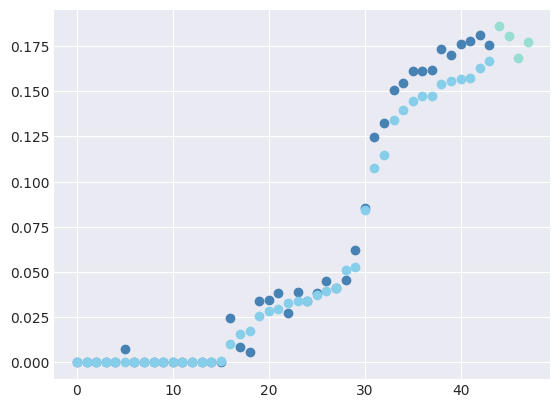

In [133]:
def train_test_graph(metrics_dict, metrics_u_dict, objective_metric):
    pareto = list(zip(metrics_dict['train'],metrics_dict[objective_metric]))
    pareto_sorted = sorted(pareto, key = lambda x: x[0])
    x = len(list(zip(*pareto_sorted))[0])
    plt.scatter(range(x), list(zip(*pareto_sorted))[1], color = '#4682B4')
    plt.scatter(range(x, x + len(metrics_u_dict[objective_metric])),metrics_u_dict[objective_metric], color = "#96DED1")
    plt.scatter(range(x), list(zip(*pareto_sorted))[0], color = '#87CEEB')
    plt.show()

train_test_graph(fair_metrics_dict, fair_metrics_u_dict, 'disparity difference')

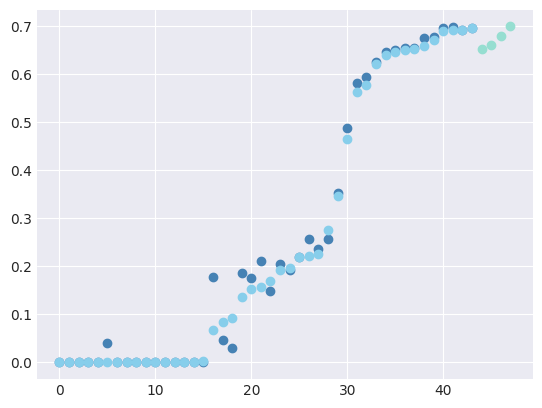

In [134]:
train_test_graph(model_metrics_dict, model_metrics_u_dict, 'f1 score')

In [151]:
import pandas as pd
metrics = [
    'predictive equality difference', 
    'equality opportunity difference',
    'average absolute odds difference',
    'disparity difference'
    ]
 
d = []
for metric in metrics:
    metric_min = np.min(fair_metrics_dict[metric])
    metric_max = np.max(fair_metrics_dict[metric])
    d.append(
        {
            'metric': metric,
            'min': metric_min,
            'max':  metric_max,
            'diff': metric_max - metric_min
        }
    )

df_ranges = pd.DataFrame(d)


In [356]:
metrics = [
    'recall', 
    'precision',
    'f1 score',
    'accuracy'
    ]
d = []
for metric in metrics:
    metric_min = np.min(df_metrics[metric])
    metric_max = np.max(df_metrics[metric])
    d.append(
        {
            'metric': metric,
            'min': metric_min,
            'max':  metric_max,
            'diff': metric_max - metric_min
        }
    )

df_model_ranges = pd.DataFrame(d)

In [451]:
results_dict['metrics_sim'][0][ni].by_group['accuracy']

sex
Female    0.919119
Male      0.787937
Name: accuracy, dtype: float64

In [486]:
results_dict['metrics_sim'][0][new_index[20]].by_group

,accuracy,precision,recall,f1 score,selection rate,false positive rate,true positive rate,false negative rate,true negative rate,count
sex,,,,,,,,,,
Female,0.919119,0.901442,0.271542,0.417362,0.032136,0.003545,0.271542,0.728458,0.996455,12945.0
Male,0.787937,0.894668,0.345338,0.498325,0.117724,0.017841,0.345338,0.654662,0.982159,26129.0


In [526]:
df_metrics

,train_fair,predictive equality difference,equality opportunity difference,average absolute odds difference,disparity difference,train_model,recall,precision,f1 score,accuracy,model
0,0.051179,0.010407,0.176387,0.093397,0.068927,0.274766,0.190160,0.903915,0.314218,0.801377,RF
1,0.155837,0.058206,0.115179,0.086692,0.170408,0.669409,0.589840,0.790908,0.675734,0.864539,GBM
2,0.166950,0.060388,0.092232,0.076310,0.175327,0.695141,0.627487,0.781641,0.696132,0.868915,LGBM
3,0.037402,0.000606,0.095765,0.048185,0.039105,0.219039,0.129412,0.990991,0.228928,0.791396,RF
4,0.147267,0.055421,0.111671,0.083546,0.161785,0.650702,0.558610,0.787427,0.653569,0.858295,GBM
5,0.041229,0.000551,0.106413,0.053482,0.041596,0.224469,0.134866,0.992132,0.237454,0.792727,RF
6,0.028526,0.000220,0.110360,0.055290,0.034099,0.151631,0.095508,0.995541,0.174295,0.783462,RF
7,0.025735,0.000110,0.096248,0.048179,0.029431,0.136290,0.082032,0.997399,0.151596,0.780289,RF
8,0.032651,0.000110,0.090435,0.045272,0.029955,0.169036,0.088663,0.997593,0.162852,0.781875,RF
9,0.029606,0.000165,0.083811,0.041988,0.029984,0.156715,0.093155,0.996568,0.170383,0.782925,RF


In [524]:
from plotly.subplots import make_subplots



def graph_eval_groups(metric_frame, metric = 'accuracy'):
    fig = make_subplots(rows=1, cols=3, shared_xaxes=False,
                        shared_yaxes=True, horizontal_spacing=0)
    y = metric_frame.by_group[metric].index
    x1 = metric_frame.by_group[metric]
    text1 = metric.capitalize()
    fig.append_trace(go.Bar(
                        x=x1, 
                        y=y,
                        text=np.round(x1,3), 
                        textposition='inside',
                        orientation='h', 
                        width=0.5, 
                        showlegend=False, 
                        marker_color='#ADD8E6'), 
                        1, 1) # 1,2 represents row 1 column 2 in the plot grid

    metric2 = 'false negative rate'
    text2 = 'FN (P=0,T=1)'
    x2 = metric_frame.by_group[metric2]
    fig.append_trace(go.Bar(
                        x=x2, 
                        y=y,
                        text=np.round(x2,3), #Display the numbers with thousands separators in hover-over tooltip 
                        textposition='inside',
                        orientation='h', 
                        width=0.5, 
                        showlegend=False, 
                        marker_color='#EEE9BF'), 
                        1, 2) # 1,1 represents row 1 column 1 in the plot grid

    metric3 = 'false positive rate'
    text3 = 'FP (P=1,T=0)'
    x3 = metric_frame.by_group[metric3]
    fig.append_trace(go.Bar(
                        x=x3, 
                        y=y,
                        text=np.round(x3,3), 
                        textposition='inside',
                        orientation='h', 
                        width=0.5, 
                        showlegend=False, 
                        marker_color='#ADD8E6'), 
                        1, 3) # 1,2 represents row 1 column 2 in the plot grid

    fig.update_xaxes(showticklabels=False,title_text= text1, row=1, col=1, title_standoff = 0, title_font = {"size": 20})
    fig.update_xaxes(showticklabels=False,title_text= text2, row=1, col=2, autorange = 'reversed', tickfont=dict(size = 28))
    fig.update_xaxes(showticklabels=False,title_text= text3, row=1, col=3, tickfont=dict(size = 28))

    #fig.update_yaxes(row = 1, col = 1, title_standoff = 50)

    fig.update_yaxes(
                    title_standoff = 20,
                        tickfont=dict(size = 16))

    return fig




n=20
metric_frame = results_dict['metrics_sim'][0][new_index[20]]
graph_eval_groups(metric_frame, 'accuracy')

In [359]:
np.min(df_metrics['precision'])

0.0

In [357]:
df_model_ranges

,metric,min,max,diff
0,recall,0.00000,0.638396,0.638396
1,precision,0.00000,0.997593,0.997593
2,f1 score,0.00000,0.697680,0.697680
3,accuracy,0.76071,0.868915,0.108205


In [336]:

def create_df_ranges(metrics, metrics_dict):
    d = []
    for metric in metrics:
        metric_min = np.min(metrics_dict[metric])
        metric_max = np.max(metrics_dict[metric])
        d.append(
            {
                'metric': metric,
                'min': metric_min,
                'max':  metric_max,
                'diff': metric_max - metric_min
            }
        )

    return pd.DataFrame(d)

metrics = [
    'predictive equality difference', 
    'equality opportunity difference',
    'average absolute odds difference',
    'disparity difference'
    ]
df_fair_ranges  = create_df_ranges(metrics, fair_metrics_dict)

In [343]:


n = 25
def comparison_graph(df_ranges, df_metrics, n):
    fig = go.Figure()
    for i in range(df_ranges.shape[0]):
        fig.add_trace(
            go.Bar(
                    x= [df_ranges['min'][i]],
                    y= [df_ranges.metric[i]],
                    width = .05,
                    marker = dict(
                        color = 'lightslategray',
                    ),
                    orientation='h'))
        fig.add_trace(
            go.Bar(
                    x= [df_ranges['diff'][i]],
                    base = [df_ranges['min'][i]],
                    y= [df_ranges.metric[i]],
                    width = .15,
                    marker = dict(
                        color = 'LightSkyBlue',
                    ),
                    orientation='h'))
        fig.add_trace(
            go.Bar(
                    x= [1-df_ranges['diff'][i]-df_ranges['min'][i]],
                    base = [df_ranges['min'][i]+df_ranges['diff'][i]],
                    y= [df_ranges.metric[i]],
                    width = .05,
                    marker =dict(
                        color = "lightslategray"
                    ),
                    orientation='h'))

        fig.add_trace(
            go.Scatter(
                x = [1],
                y = [df_ranges.metric[i]], 
                mode = 'markers+text',
                text = ['1'],
                textposition="bottom center",
                marker=dict(size=10,
                            symbol = 'line-ns',
                            line=dict(width=2,
                            color='lightslategray')
            ))
        )

        fig.add_trace(
            go.Scatter(
                x = [0],
                y = [df_ranges.metric[i]], 
                mode = 'markers+text',
                text = ['0'],
                textfont_size=12,
                textposition="bottom center",
                marker=dict(size=10,
                            symbol = 'line-ns',
                            line=dict(width=2,
                            color='lightslategray')
            ))
        )

        fig.add_trace(
            go.Scatter(
                    x= [df_metrics.loc[n,df_ranges.metric[i]]],
                    y= [df_ranges.metric[i]],
                    mode = 'markers+text',
                    textposition = "bottom center",
                    text = [np.round(df_metrics.loc[n,df_ranges.metric[i]],2)],
                    marker =dict(
                        size = 5,
                        color = "mediumaquamarine",
                        symbol = 'line-ns',
                        line_width=2,
                    ),
                    orientation='h'))

    fig.update_layout(
        xaxis=dict(showgrid=False, tickwidth = .3,),
        yaxis=dict(showgrid=False, tickwidth = .3),
        showlegend=False,
        barmode='stack',
    )

    return fig


comparison_graph(df_fair_ranges, df_metrics, n)


In [ ]:
df_data = {'Category': ['London', 'Paris', 'New York', 'Tokyo'],
           'Upper': [10, 5, 0, -5],
           'Lower': [5, -5, -10, -10]}
df = pd.DataFrame(data=df_data)
df['Height'] = df['Upper'] - df['Lower']

ax = df.plot(kind='bar', y='Height', x='Category', bottom=df['Lower'],
             color='darkgreen', legend=False)
ax.axhline(0, color='black')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plt.style.use('seaborn-v0_8-darkgrid')

rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    ax.scatter(res_fair_sim[i], res_model_sim[i])
    ax.scatter(fair_sim_u[i], model_sim_u[i])


In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[0])
    #ax.scatter(len(res_fair_sim[i]*4), fair_sim_u[i])
    ax.scatter(range(len(res_fair_sim[i])), list(zip(*fairness_metrics_))[1])


In [ ]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(res_model_sim)),axes.ravel()):
    performance_metrics = list(zip(res_model_sim[i], model_sim[i]))
    performance_metrics_ = sorted(performance_metrics, key = lambda x: x[0])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[0])
    #ax.scatter(len(res_model_sim[i]), model_sim_u[i])
    ax.scatter(range(len(res_model_sim[i])), list(zip(*performance_metrics_))[1])

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    fairness_metrics = list(zip(res_fair_sim[i], fair_sim[i]))
    fairness_metrics_ = sorted(fairness_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*fairness_metrics_))[0])-np.array(list(zip(*fairness_metrics_))[1])
    ax.hist(fair_residuals)

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    model_metrics = list(zip(res_model_sim[i], model_sim[i]))
    model_metrics_ = sorted(model_metrics, key = lambda x: x[0])
    fair_residuals = np.array(list(zip(*model_metrics_))[0])-np.array(list(zip(*model_metrics_))[1])
    ax.hist(fair_residuals)

In [ ]:
optuna.visualization.plot_pareto_front(results[0], target_names=["fair_metric", "f1_score"], include_dominated_trials = False)